# QR Watermarking

In this notebook, we'll be using the LSB scheme for watermarking by including property data in an image.

Note that LSB is one of the simpliest method for watermarking, and therefore is easily exploitable! However, this may be a good starting point for learning more robust schemes in a future.

In [1]:
import uuid

import matplotlib.pyplot as plt
import numpy as np
import qrcode

from skimage import util
from skimage.filters import gaussian
from skimage.io import imread, imshow


## Message encoding

For encoding the watermark, we'll be using QR codes, which provide a certain ammount of fault tolerance (We'll be evaluating it soon enough!) The `qrcode` module already provides the logic for encoding and decoding such messages. Note that this message could be further encrypted as needed. Here, the message is an *Universally Unique Identifier*, or UUID.

In [2]:
copyright_message = uuid.uuid4().hex

qr = qrcode.QRCode(
    box_size=1,
    border=0,
)
qr.add_data(copyright_message)
qr.make(fit=True)

watermark = qr.make_image(fill_color="black", back_color="white")
watermark = np.array(watermark)

A QR code looks as follow:

(29, 29)


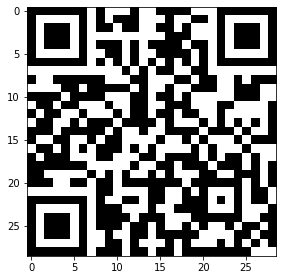

In [3]:
print(watermark.shape)
imshow(watermark)

It is a square binary image containing our data. We can handle these pixels as-is: white = 1, black = 0. This specific version has 29x29 bit: 841 bits. This means we need 841 postions in the host image. We can handle this by doing it sequentially as we did in the past notebook, or we can use a selection scheme. 

Here, we'll generate 841 pairs of numbers indicating (pixel, channel) and we'll put the next bit there.

First, we need to have a host image. I'm going to use a photo I took from some skulls for the "Día de Muertos"

(720, 1280, 3)


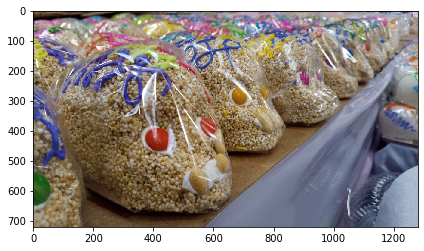

In [4]:
host = imread("data/day-of-the-death.jpeg")
print(host.shape)
imshow(host);

We can add up to 720x1280 bits of information into this image... Which is not a good idea! In steganopgraphy, there is a tradeoff between capacity and imperciptibility. If we add to much data, it will be more visible to the final user! However, we just need 841 bits, and therefore we should be OK. 

Now we generate the key positions to store the bits. There are many better ways to do this, but I am new at this. Therefore, I'll be simply generating random numbers and store them as a key to decode the watermark.

In [5]:
def generate_key(image_shape, key_size):
    """Generate a random key with random channels and pixels"""
    pixels = image_shape[0] * image_shape[1]
    flat_axis = np.random.permutation(np.arange(0, pixels))[:key_size]
    channel_axis = np.random.randint(0, image_shape[2], key_size)
    key = np.array(list(zip(flat_axis, channel_axis)))
    return key

key = generate_key(host.shape, 841)

Great! Now let's embed our bits.

## Watermark embedding

Now we have the host image and the key to store our bits. Let's define some utility functions to manipulate the LSB from a byte.

In [6]:
def set_bit(value, index=0):
    """Set the bit at `index` location to 1 in `value`"""
    mask = 1 << index
    return value | mask

def clear_bit(value, index=0):
    """Set the bit at`index` location to 1 in `value`"""
    mask = 1 << index
    return value & ~mask

Now we iterate over the watermark, pairing each bit to its correspondent possition according to the key. Copy the host image to preserve the original one. 

In [7]:
def watermark_embedding(host, watermark, key):
    original_shape = host.shape
    host_watermark = np.copy(host).reshape((-1, original_shape[2]))
    for wm_bit, location in zip(watermark.ravel(), key):
        pixel = host_watermark[location[0]]
        pixel[location[1]] = set_bit(pixel[location[1]]) if wm_bit else clear_bit(pixel[location[1]])

    host_watermark = host_watermark.reshape(original_shape)
    return host_watermark

host_watermark = watermark_embedding(host, watermark, key)

Now we have watermarked our image! Let's evalute it.

## Evaluating the results

We'll evaluate the results by two perspectives: Subjective and Objective. 

Basically, the subjective is to detect any notable change by using the HVS (Human Vision System) and for the objective one, we'll use MSE.

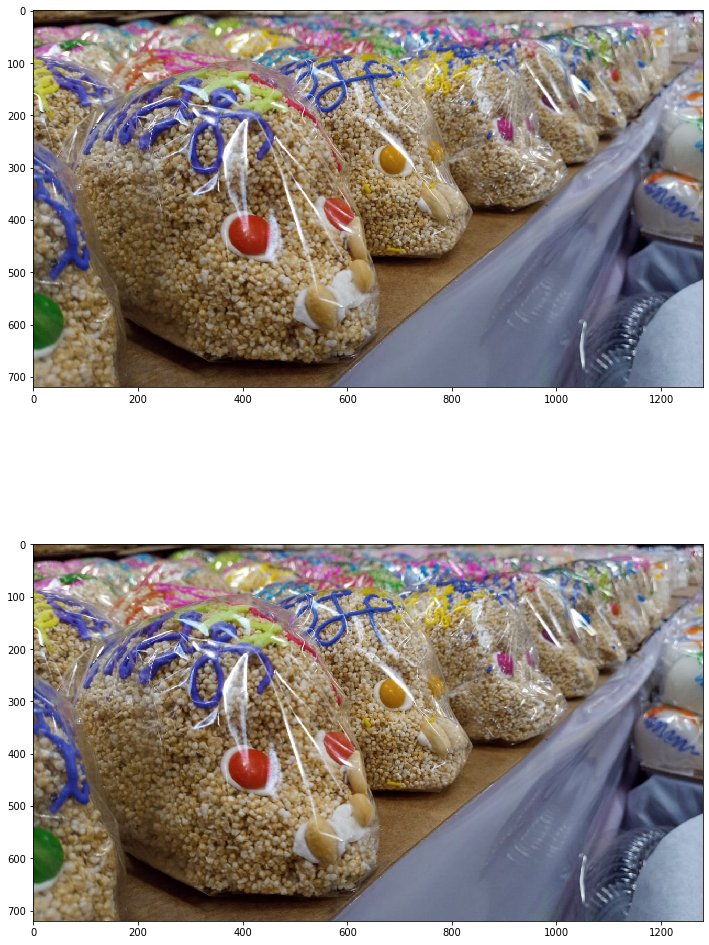

In [8]:
fig, (original, watermarked) = plt.subplots(nrows=2, ncols=1, figsize=(12, 18))
original.imshow(host)
watermarked.imshow(host_watermark);

For one subject (me) there is not perceptible evidence! Now let's calculate the Mean Squared Error.

Also, I'll calculate the L2 norm to measure the Euclidean distance from a unaltered image and a water marked image.

In [9]:
def mse(cover, watermaked):
    """Computes the Mean Squared Error"""
    diff = (watermaked - cover).ravel().astype("float32")
    return np.mean(np.square(diff))

In [10]:
mse(host_watermark, host)

5.0801587

In [11]:
np.linalg.norm(host_watermark - host)

3807.990414903903

Not that bad, considering we've changed 841 values. Now let's retreive it!

## Watermark Extraction

We need to extract the watermark from the image at a certain moment, according to our application. Here, we embedded an unique ID to the image to know that this is OUR image.

As we used a random array as key, we need that random array to properly extract the QR code, otherwise we'll get just random noise (with a very small posibility to retreive the QR code!) First, we need a way to retrieve the LSB from the specified bytes.

In [12]:
def get_lsb(value):
    """Returns the LSB from `value`"""
    return value & 1

Now, we iterate over the key values and start constructing the original QR code

In [13]:
def extract_watermark(host_watermark):
    decoded_watermark = []
    host_watermark = host_watermark.reshape((-1, 3))
    
    for location in key:
        pixel = host_watermark[location[0]]
        wm_bit = get_lsb(pixel[location[1]])
        decoded_watermark.append(wm_bit)
    
    return decoded_watermark

extracted_watermark = extract_watermark(host_watermark)

At this point, we have the watermark data. However, in our application we embedded a QR code and we need to decode it.

## Watermark Decoding

At this point, we have a flattened representation of the QR code. We need to give it a proper shape of 29x29.

In [14]:
decoded_watermark = np.array(extracted_watermark, dtype="bool").reshape((29, 29))

And let's see if it is good!

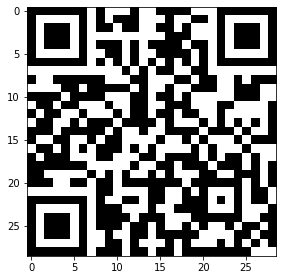

In [15]:
imshow(decoded_watermark);

In [16]:
np.alltrue(decoded_watermark == watermark)

True

Great!! We correctly recovered perfetly our watermark (This method will fail if they make modifications to the image, though)

/home/saltyprogrammer/.envs/Research/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


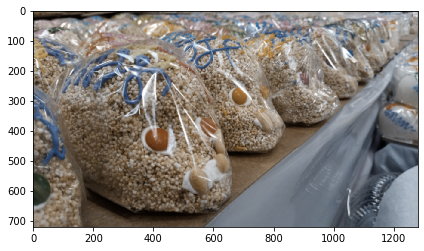

In [17]:
modified = gaussian(host_watermark, multichannel=False)
modified_extracted_watermark = extract_watermark(util.img_as_ubyte(modified))
modified_decoded_watermark = np.array(modified_extracted_watermark, dtype="bool").reshape((29, 29))
imshow(modified);


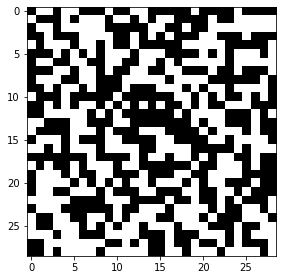

In [18]:
imshow(modified_decoded_watermark)

Our QR code didn't survived a Gaussian manipulation...

In [19]:
np.alltrue(modified_decoded_watermark == watermark)

False